# Dependencias

In [151]:
import os
import time

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import datasets, layers, models, callbacks, optimizers
from keras.utils.vis_utils import plot_model

from lib.data_normalizer import draw_image_with_boxes

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

IMAGE_SHAPE = (227,227)

# Modelo de identificación de placas

In [152]:
res_net_50 = tf.keras.applications.ResNet50( input_tensor = layers.Input(
    shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    include_top=False,
    weights='imagenet')

# Function to create model, taking ResNet50 as first layers
def create_model(no_of_classes):

    # Allow the model to be trained
    res_net_50.trainable = True

    # Start by taking the output feature maps from ResNet50
    base_model_output = res_net_50.output

    # Flatten the output feature maps to a 1D vector with GlobalAveragePooling2D, more effective than Flatten
    # due to a reduction in the number of parameters and better control of overfitting.
    flattened_output = layers.GlobalAveragePooling2D()(base_model_output)

    # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = layers.Dense(256, activation="relu")(flattened_output)
    box_output = layers.Dense(128, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output )

    box_output = layers.Dense(64, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output )

    box_output = layers.Dense(32, activation="relu")(box_output)
    box_predictions = layers.Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Create Our Classification Head, final layer contains one neuron that determines if the image contains a plate
    # or not.
    class_prediction = layers.Dense(256, activation="relu")(flattened_output)
    class_prediction = layers.Dense(128, activation="relu")(class_prediction )
    class_prediction = layers.Dropout(0.2)(class_prediction)
    class_prediction = layers.Dense(64, activation="relu")(class_prediction)
    class_prediction = layers.Dropout(0.2)(class_prediction )
    class_prediction = layers.Dense(32, activation="relu")(class_prediction)
    class_prediction = layers.Dense(1, activation='softmax',name="class_output")(class_prediction)

    # Now combine the two heads to get the final model
    model = models.Model(inputs=res_net_50.input, outputs= [box_predictions, class_prediction])

    return model

# Create the model for 1 class
model = create_model(1);
plot_model(model, to_file='models/model_plot.png', show_shapes=True, show_layer_names=True)

# Loss function for each head

# For classification we will have categorical crossentropy
# For the boundary boxes we will have mean squared error
losses = {
    "box_output": "mean_squared_error",
    "class_output": "binary_crossentropy"
    }

# Here you can give more or less weight to each loss.

# If you think that detection is harder then the classification then you can
# Try assigning it more weight
# 6.7 % of the images that don't contain a plate, so we will give it more weight

loss_weights = {
    "box_output": 0.933,
    "class_output": 0.067
}

# Set the Metrics
# For the class labels we want to know the Accuracy
# And for the bounding boxes we need to know the Mean squared error
metrics = {
    'box_output':  'mse',
    'class_output': 'accuracy',
}

# We will be using early stopping to stop the model if total val loss does not
# Decrease by 0.001 in 40 epochs
stop = callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40,
                    restore_best_weights = True)

# Change the learning rate according to number of epochs to boost learning
reduce_lr = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002,
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = optimizers.SGD(learning_rate = 1e-2, momentum = 0.9)

# Compile the model with Adam optimizer
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights,
    metrics = metrics)

# Carga de Datos

In [153]:
# Load csv
plates_data = pd.read_csv("./normalized_data/unique_plates.csv")

# Take two mutual exclusive samples of the data for training and validation
train_plates = plates_data.sample(frac=0.8,random_state=200)
test_plates = plates_data.drop(train_plates.index)



# Create the arrays with the inputs and outputs for testing and training data
# training vectors
train_plates_data_in = np.ndarray(shape=(len(train_plates), IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
train_plates_data_out_box = np.array([train_plates['xmin'],
                                      train_plates['ymin'],
                                      train_plates['xmax'],
                                      train_plates['ymax']]).T
train_plates_data_out_tag = np.array([train_plates['tag'],]).T
# testing vectors
test_plates_data_in = np.ndarray(shape=(len(train_plates), IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
test_plates_data_out_box = np.array([test_plates['xmin'],
                                     test_plates['ymin'],
                                     test_plates['xmax'],
                                     test_plates['ymax']]).T
test_plates_data_out_tag = np.array([test_plates['tag'],]).T



# Load train images into RAM from paths in csv
for i, path in enumerate(train_plates['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    train_plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels from BGR -> RGB

# Normalize inputs
for i in range(len(train_plates_data_out_box)):
    train_plates_data_out_tag[i][0] = train_plates_data_out_tag[i][0] / 100             # tag
    train_plates_data_out_box[i][0] = train_plates_data_out_box[i][0] / IMAGE_SHAPE[0]  # xmin
    train_plates_data_out_box[i][1] = train_plates_data_out_box[i][1] / IMAGE_SHAPE[1]  # ymin
    train_plates_data_out_box[i][2] = train_plates_data_out_box[i][2] / IMAGE_SHAPE[0]  # xmax
    train_plates_data_out_box[i][3] = train_plates_data_out_box[i][3] / IMAGE_SHAPE[1]  # ymax



# Test de datos

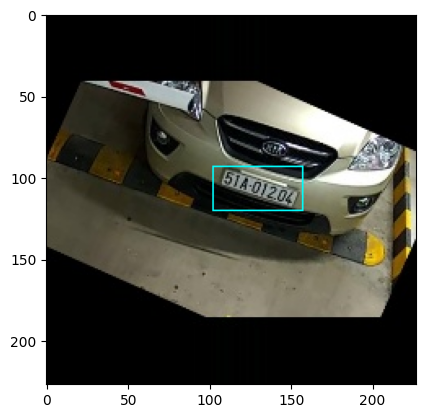

In [154]:
i = np.random.randint(0, len(train_plates_data_in))
# Scale predicted data
predicted_data = [[0.0,0.0,0.0,0.0,0.0]]
predicted_data[0][1] = train_plates_data_out_box[i][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][2] = train_plates_data_out_box[i][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][3] = train_plates_data_out_box[i][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][4] = train_plates_data_out_box[i][3] * IMAGE_SHAPE[1]  # ymax

draw_image_with_boxes(train_plates_data_in[i], predicted_data, border = 1)


# Entrenamiento

In [ ]:
# Train the Model
history = model.fit(x = train_plates_data_in,
                    y = {
                        "box_output": train_plates_data_out_box,
                        "class_output": train_plates_data_out_tag
                    },
                    validation_split=0.2,
                    batch_size = 32, epochs = 200,
                    callbacks=[reduce_lr, stop])
model.save('models/ResNet50ClassBox_01.h5')


# Métricas de entrenamiento

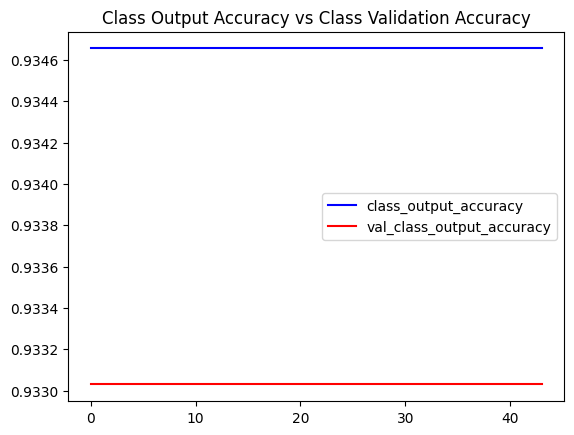

In [137]:
def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history.history[var1]
    c2 = history.history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

# plot('box_output_mse','val_box_output_mse','Box Output MSE vs Box Validation MSE')
# plot('box_output_loss','val_box_output_loss','Box Output Loss vs Box Validation Loss')
# These are the most important metrics in telling us how our model is doing

plot( 'class_output_accuracy', 'val_class_output_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')


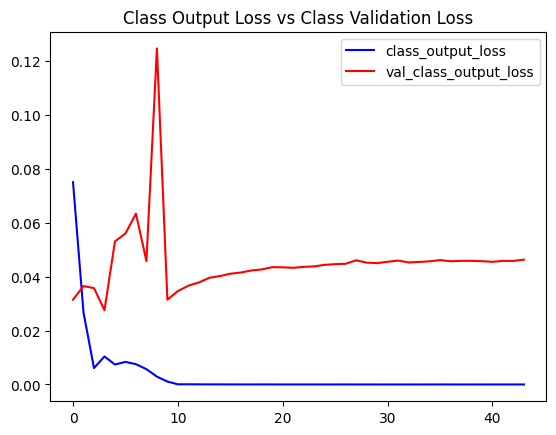

In [138]:
plot( 'class_output_loss', 'val_class_output_loss', 'Class Output Loss vs Class Validation Loss')


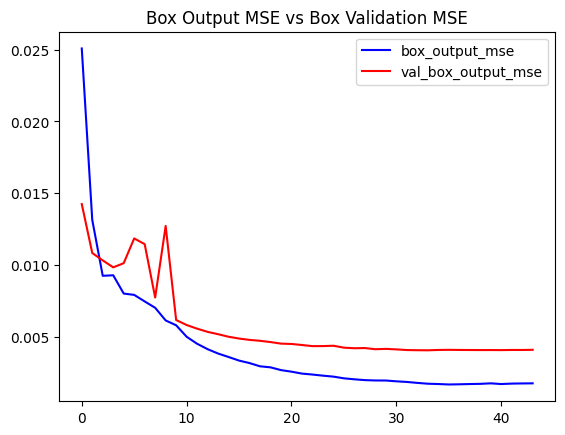

In [139]:
plot( 'box_output_mse', 'val_box_output_mse', 'Box Output MSE vs Box Validation MSE')


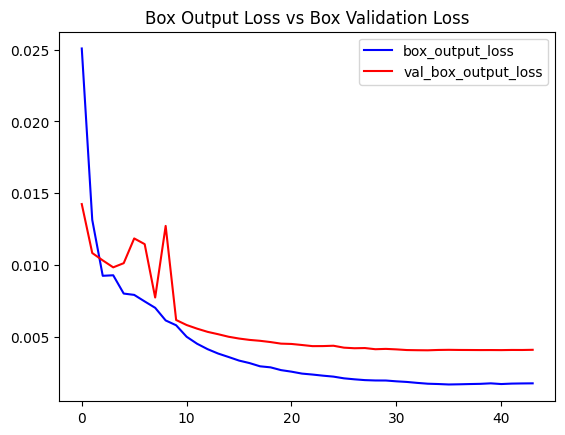

In [140]:
plot('box_output_loss', 'val_box_output_loss', 'Box Output Loss vs Box Validation Loss')


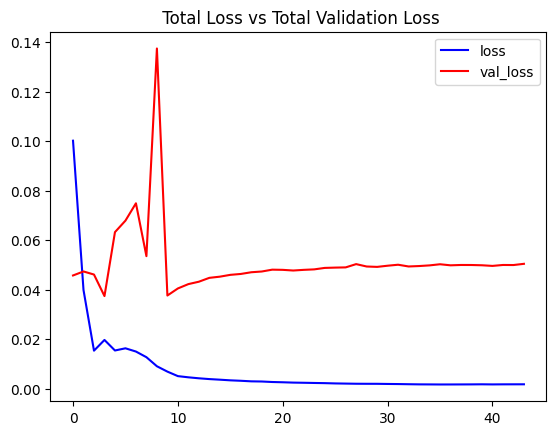

In [141]:
plot('loss','val_loss',' Total Loss vs Total Validation Loss')

# Métricas de validación

In [142]:
# Load train images into RAM from paths in csv
for i, path in enumerate(train_plates['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    train_plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels from BGR -> RGB

# Normalize inputs
for i in range(len(train_plates_data_out_box)):
    train_plates_data_out_tag[i][0] = train_plates_data_out_tag[i][0] / 100             # tag
    train_plates_data_out_box[i][0] = train_plates_data_out_box[i][0] / IMAGE_SHAPE[0]  # xmin
    train_plates_data_out_box[i][1] = train_plates_data_out_box[i][1] / IMAGE_SHAPE[1]  # ymin
    train_plates_data_out_box[i][2] = train_plates_data_out_box[i][2] / IMAGE_SHAPE[0]  # xmax
    train_plates_data_out_box[i][3] = train_plates_data_out_box[i][3] / IMAGE_SHAPE[1]  # ymax

# Usar modelo

2022-11-27 02:52:51.266392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 525ms/step
Salida: [array([[0.414, 0.53 , 0.464, 0.538]], dtype=float32), array([[1.]], dtype=float32)]


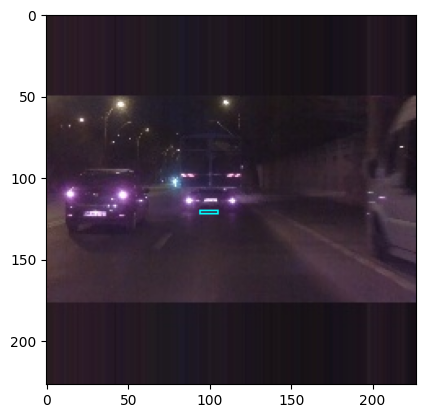

In [150]:


def resize_image(image: np.ndarray, desired_resolution: tuple) -> np.ndarray:
    """
    Resize an image to a given size
    :param image: Image to resize
    :param size: Size to resize to
    :return: Resized image
    """

    # return cv2.resize(image, desired_resolution, interpolation=cv2.INTER_AREA)
    return image


model = models.load_model("./models/ResNet50ClassBox_01.h5")

input_image = cv2.cvtColor(cv2.imread("/mnt/d/Descargas/test.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
input_image = cv2.cvtColor(cv2.imread("./normalized_data/plates_images/1000.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

test_image = np.ndarray(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
#test_image[0] = resize_image(input_image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
test_image[0] = train_plates_data_in[np.random.randint(0, len(train_plates_data_in))]

predicted_data = model.predict(test_image)
print("Salida: " + str(predicted_data))
predicted_box = predicted_data[0]

# Scale predicted data
predicted_box[0][0] = predicted_box[0][0] * IMAGE_SHAPE[0]  # xmin
predicted_box[0][1] = predicted_box[0][1] * IMAGE_SHAPE[1]  # ymin
predicted_box[0][2] = predicted_box[0][2] * IMAGE_SHAPE[0]  # xmax
predicted_box[0][3] = predicted_box[0][3] * IMAGE_SHAPE[1]  # ymax

printable_data = [[0, predicted_box[0][0], predicted_box[0][1], predicted_box[0][2], predicted_box[0][3]]]

# predicted_data[0][1] = 10  # xmin
# predicted_data[0][2] = 10  # ymin
# predicted_data[0][3] = 100  # xmax
# predicted_data[0][4] = 100  # ymax

draw_image_with_boxes(test_image[0], printable_data, border = 1)